# EDA general and on the cloud mask data (CLM)
*by Max*

In this notebook we'll do some general EDA and also focus on the cloud mask data (CLM).

We start with importing the modules and loading the data.

In [2]:
# import the needed modules
import numpy as np
import pandas as pd
import math

# import own modules from the scr folder
import sys
sys.path.append('../src/')
from train_test_function import train_test_split_fields
from eda_functions import get_cloudmask_frame, get_info_per_field_id

# Set a random seed
RSEED = 42
np.random.seed(RSEED)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import plotting modules and style
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(context='notebook', style='darkgrid', palette='crest', font='helvetica')
cmap = sns.color_palette('crest', as_cmap=True)
sns.set(rc={"figure.dpi":300})
sns.set(rc = {"figure.figsize":(6,3)})

In [3]:
# set the directory of the data 
OUTPUT_DIR = '../data'

# load the base data from the CSV files
df = pd.read_csv(f'{OUTPUT_DIR}/mean_band_perField_perDate.csv')
df.head()

,field_id,date,label,B02,B03,B04,B08,B11,B12,CLM
0,1,2017-04-01,4,21.934084,29.180065,35.554660,62.490353,68.39710,46.040190,255.0
1,1,2017-04-11,4,14.844051,23.114147,30.607718,58.736336,73.43569,48.863342,0.0
2,1,2017-04-21,4,13.385852,21.596462,29.223473,57.065918,73.66881,49.313503,0.0
3,1,2017-05-01,4,15.408361,22.471062,29.371382,56.434082,71.05788,46.557877,0.0
4,1,2017-05-11,4,54.829582,65.739550,72.906750,95.672030,66.14791,58.643085,255.0


In [11]:
# convert the date column to datetime object
df['date'] = pd.to_datetime(df['date'])
# calculate the days from april as column to get a relative time
df['days_from_april'] =  df['date'] - pd.to_datetime('2017-04-01')
df['days_from_april'] = df['days_from_april'].dt.days

# calculate the month of each entry
df['month'] = pd.DatetimeIndex(df['date']).month
# create a name list of the available months
month_names = ['April', 'Mai', 'June', 'July', 'August', 'September', 'October', 'November']
# create a column in the data frame with the month names
df['month_name'] = df['month'].astype(str)
for month_nr, month_name in zip(sorted(df['month'].unique()), month_names):
    df['month_name'] = df['month_name'].str.replace(str(month_nr), month_name)

In [12]:
# do the train-test-split
df_train, df_test = train_test_split_fields(df, train_size=0.7, random_state=RSEED)

We can see that we have different means for each of band over all the fields. Also the standard deviation is quiet different. B02, B03, B04, and B08 have higher stds compared to B11 and B12. It also seems like most bands have skewed distributions.

In [13]:
# descriptive statistics for the train data set
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
field_id,3011081.0,61522.439566,35324.479169,1.0,31097.000000,61389.000000,92075.000000,122736.0
label,3011081.0,4.356439,2.181953,1.0,3.000000,4.000000,6.000000,9.0
B02,3011081.0,57.167181,73.011264,0.0,13.312826,21.866667,63.429832,255.0
B03,3011081.0,63.935131,66.920963,0.0,22.855030,34.070255,69.083336,255.0
B04,3011081.0,70.078116,63.047463,0.0,28.795986,47.404408,80.209390,255.0
B08,3011081.0,99.083999,52.963478,0.0,66.943130,83.033540,110.469090,255.0
B11,3011081.0,89.900409,32.147673,0.0,67.625000,88.449440,111.147440,255.0
B12,3011081.0,70.378639,30.275073,0.0,47.898617,68.606064,91.149500,255.0
CLM,3011081.0,87.260245,120.983540,0.0,0.000000,0.000000,255.000000,255.0
days_from_april,3011081.0,135.985744,67.526041,0.0,90.000000,140.000000,195.000000,243.0


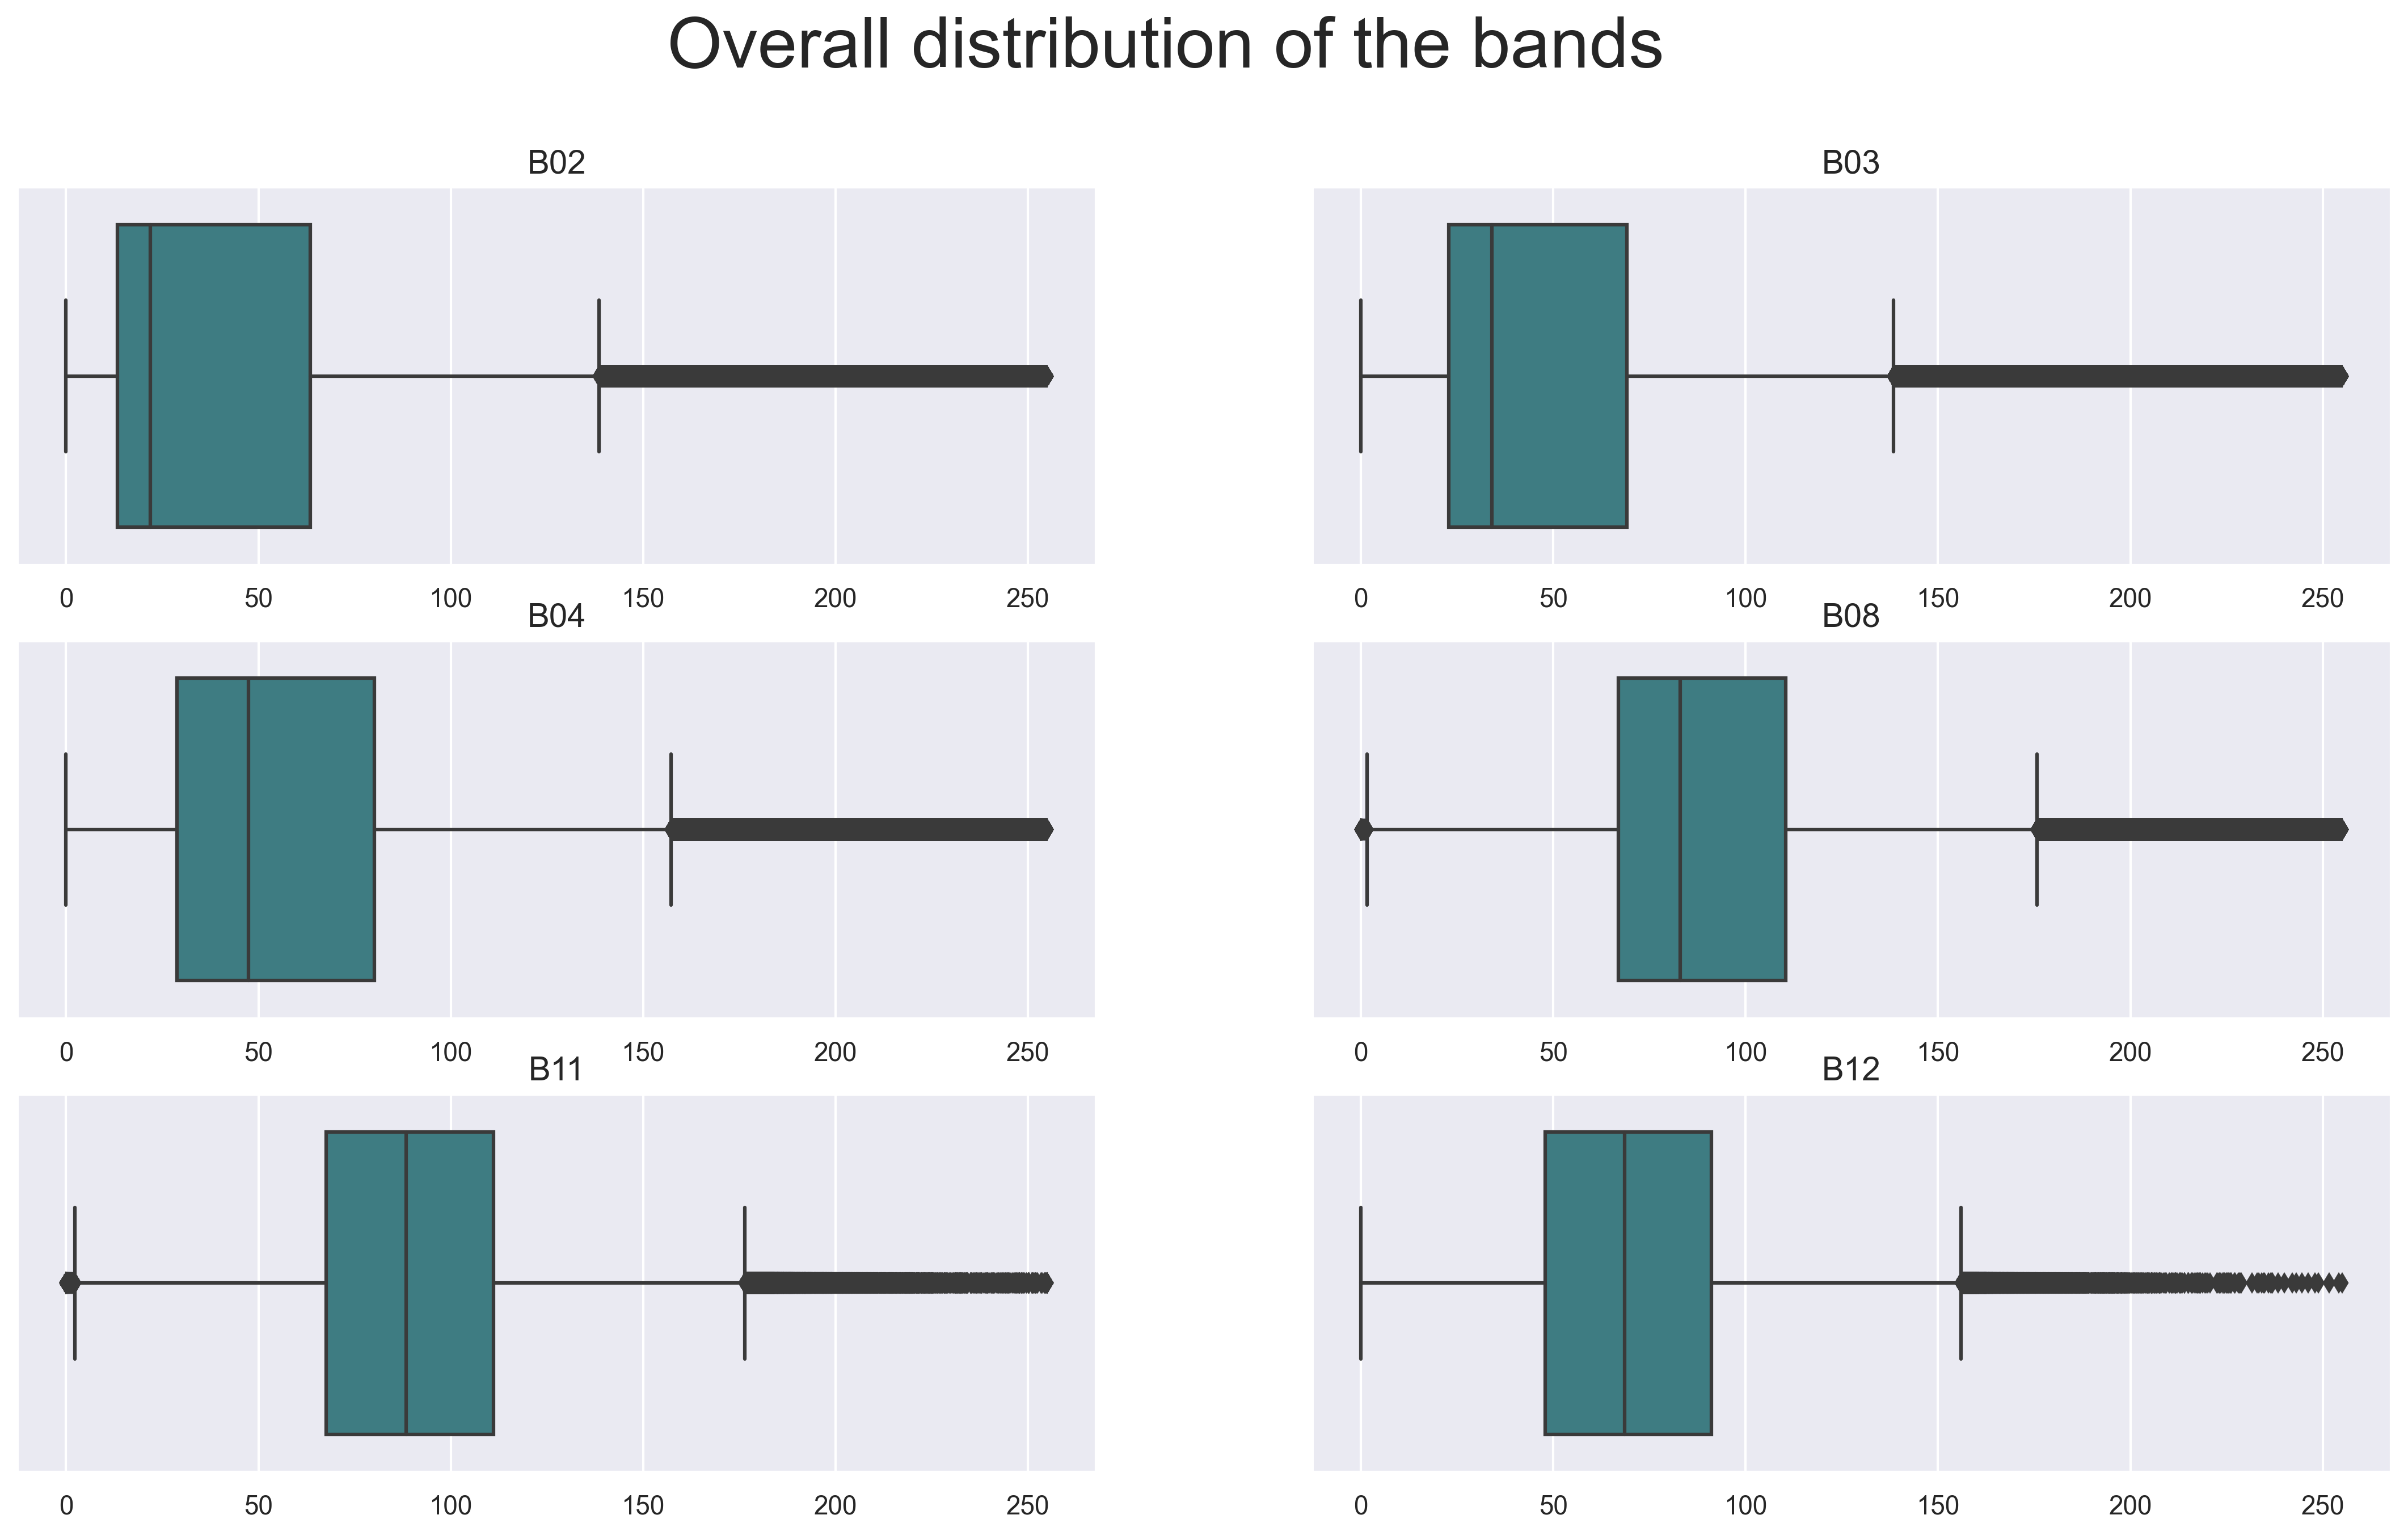

In [15]:
# create a list of the B0 bands
bands = df_train.columns.to_list()
for column in ['field_id', 'label', 'CLM', 'days_from_april', 'date', 'month', 'month_name']:
    bands.remove(column)

# set the big figure and axes
fig, axs = plt.subplots(3,math.ceil(len(bands)/3), figsize=(18,10))
fig.suptitle('Overall distribution of the bands', fontsize = 30)

# plot the different bands on the axes
for band, ax in zip(bands, axs.ravel()):
    sns.boxplot(x=band, hue='label', ax=ax, data=df_train, palette='crest')
    ax.set_title(band, fontsize=14)
    ax.set_xlabel('')
    
plt.show();

Another important general point is the question, for which fields are how many observations available in which month? 
We see that we have in general fewer observations for each field in the early month (April till June).

In [16]:
# create a data frame with the number of observations for each field in each month
month_df = get_info_per_field_id(df_train, 'month_name')
month_df

,Field_ID,Month_Name,Count
0,1,April,3
1,2,April,3
2,4,April,3
3,6,April,3
4,8,April,3
...,...,...,...
487707,122727,September,9
487708,122728,September,4
487709,122729,September,4
487710,122732,September,5


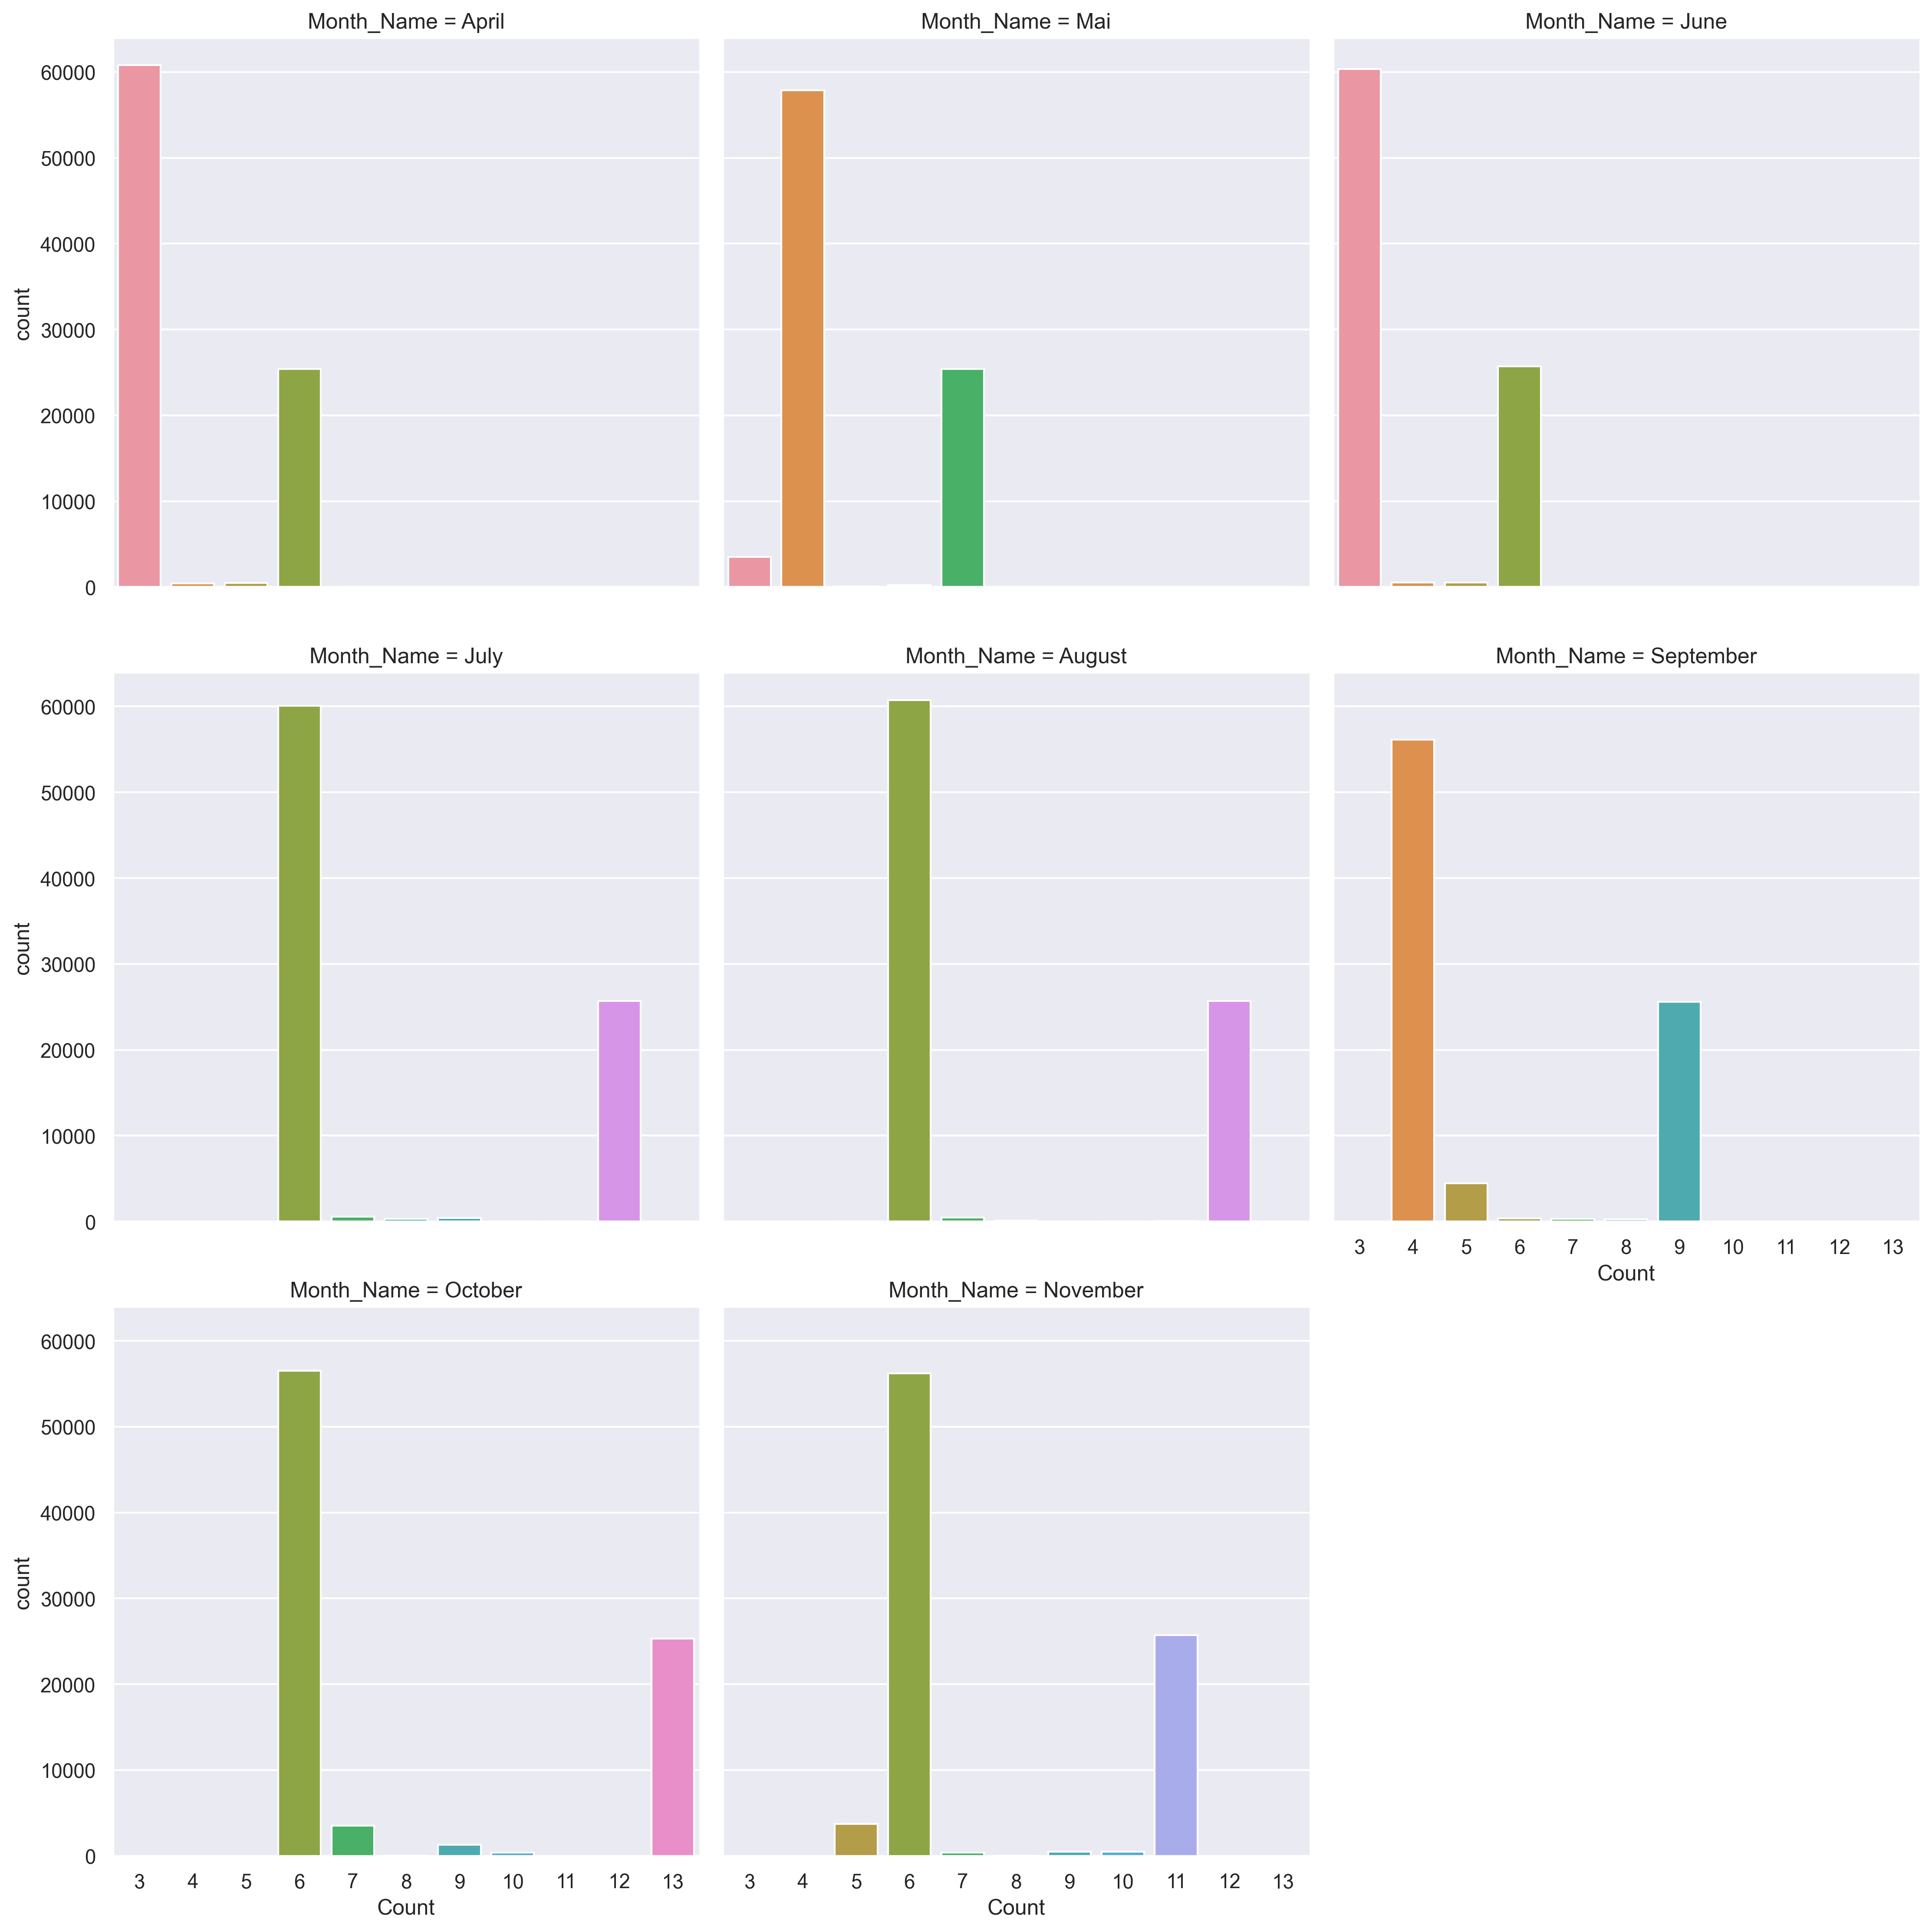

In [9]:
sns.catplot(
    kind='count', x='Count', 
    col='Month_Name', 
    col_wrap=3, 
    col_order=['April', 'Mai', 'June', 'July', 'August', 'September', 'October', 'November'], 
    data=month_df);

However, at least we also see that we have indeed for each field id information in every month.

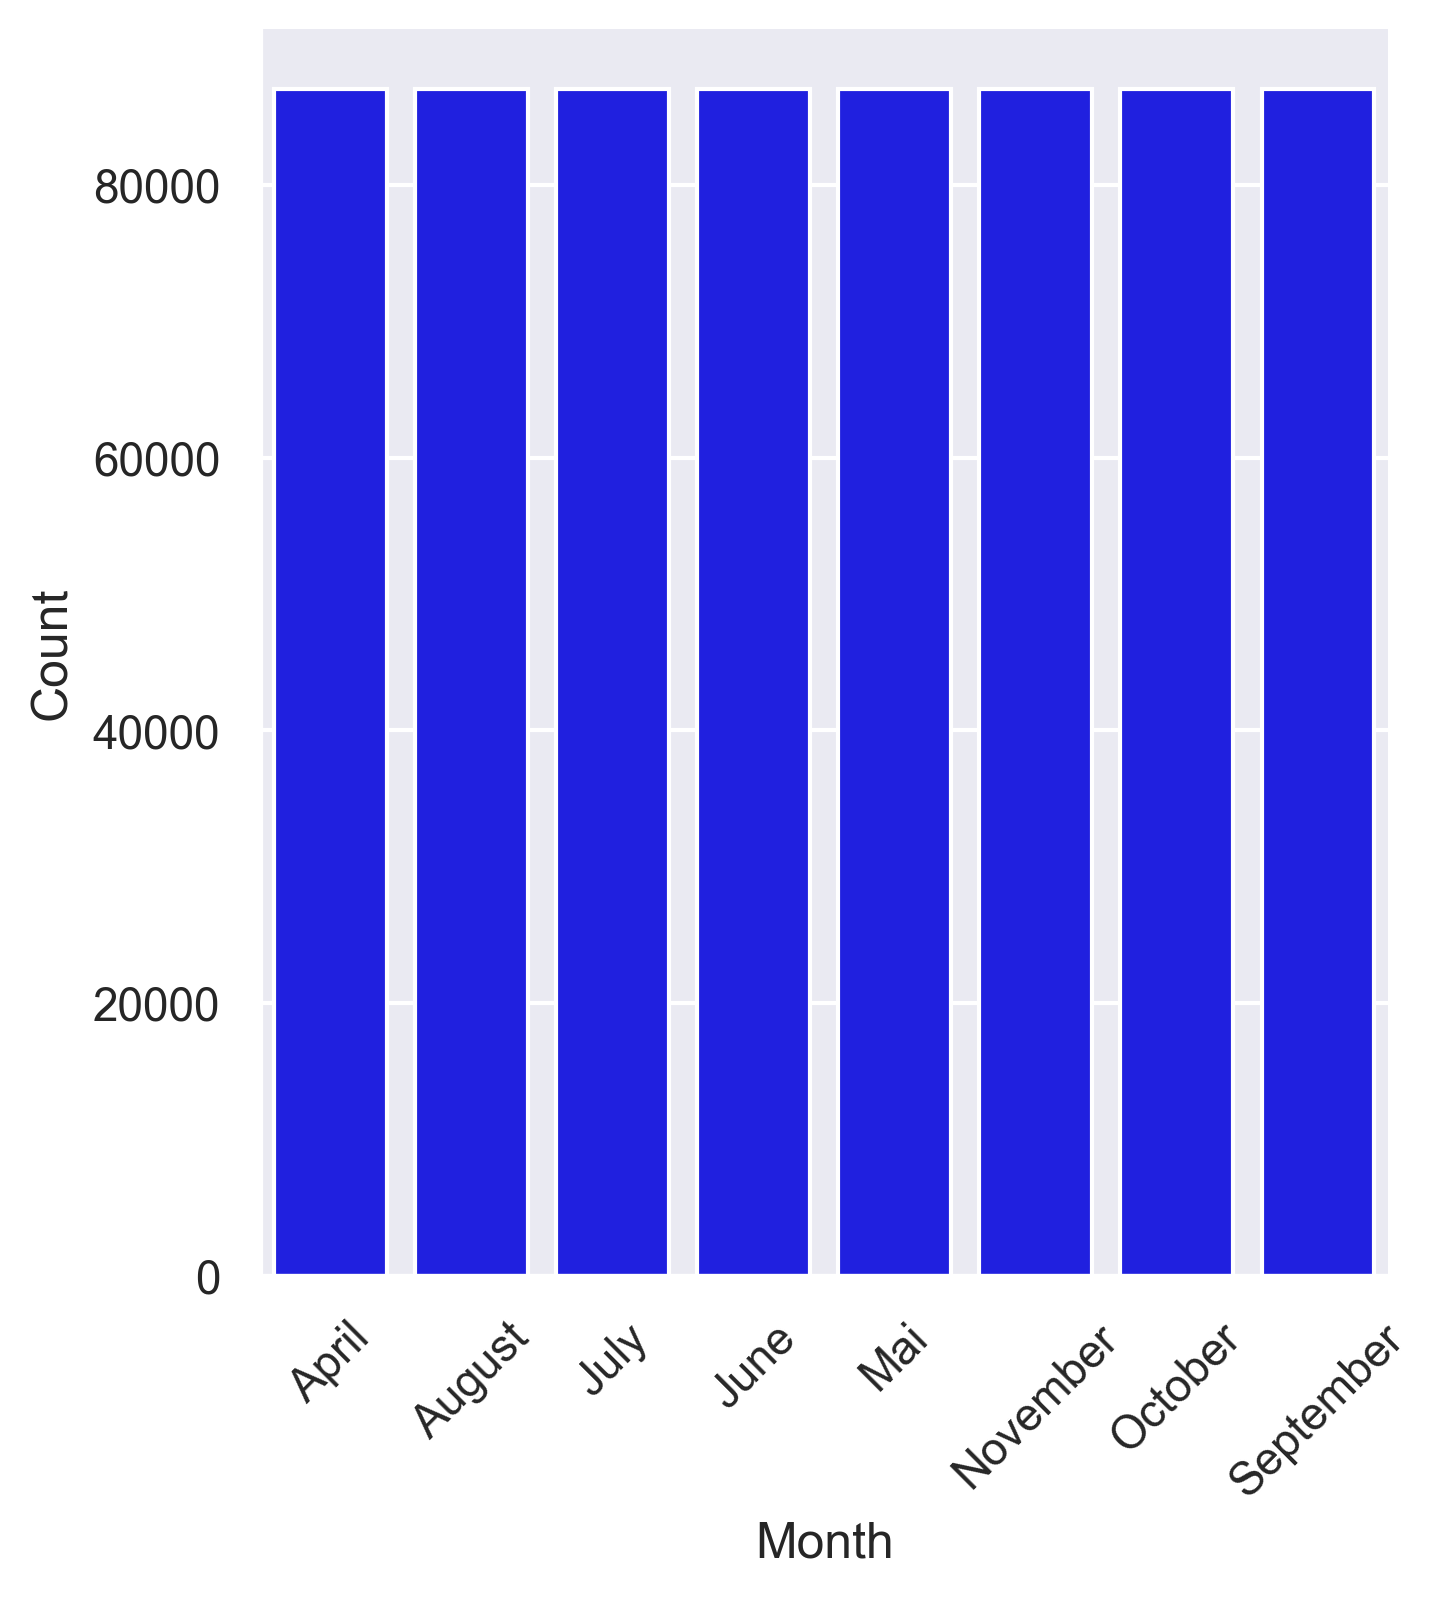

In [10]:
chart = sns.catplot(kind='count', x='Month_Name', data=month_df, color='blue')
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45, horizontalalignment='center');

For the CLM data we first look at the possible values in our data. Normally it should show observations of 0 for unclouded days, 1 for clouded days and 255 if no information is given.

The CLM has only values between 0 and 255. And for the overall observations of the training data, there are 24% that are missing the cloud mask information.

In [8]:
df_train.CLM.unique()

array([255.,   0.])

In [9]:
print(f"Number of observations with no CLM info: {df_train[df_train['CLM']==255]['CLM'].count()}")
print(f"Number of overall observations: {df['CLM'].count()}")
print(f"Percent of data without information: {round(df_train[df_train['CLM']==255]['CLM'].count() / df['CLM'].count(), 4)*100}%")

Number of observations with no CLM info: 1030383
Number of overall observations: 4301227
Percent of data without information: 23.96%


In [10]:
# set the field id as data frame index
df_train_perID = df_train.set_index(['field_id'])

The next step is the plotting of the CLM information with regards to the label. We are interested in the distribution of unclouded and no information for each label. 

In [11]:
# get data frame for the CLM of the labels
cloudmask_labels = get_cloudmask_frame(df, 'label')
cloudmask_labels

,Label,CLM,Count
0,1,unclouded,249946
1,2,unclouded,424976
2,3,unclouded,303266
3,4,unclouded,695287
4,5,unclouded,317990
5,6,unclouded,279713
6,7,unclouded,334261
7,8,unclouded,43012
8,9,unclouded,179751
9,1,no information,137952


We can see that the unclouded and no information states are equally distributed over all the classes. One option to handle the no information data for the modelling would therefore be to discarded, as we have a lot of observations. 

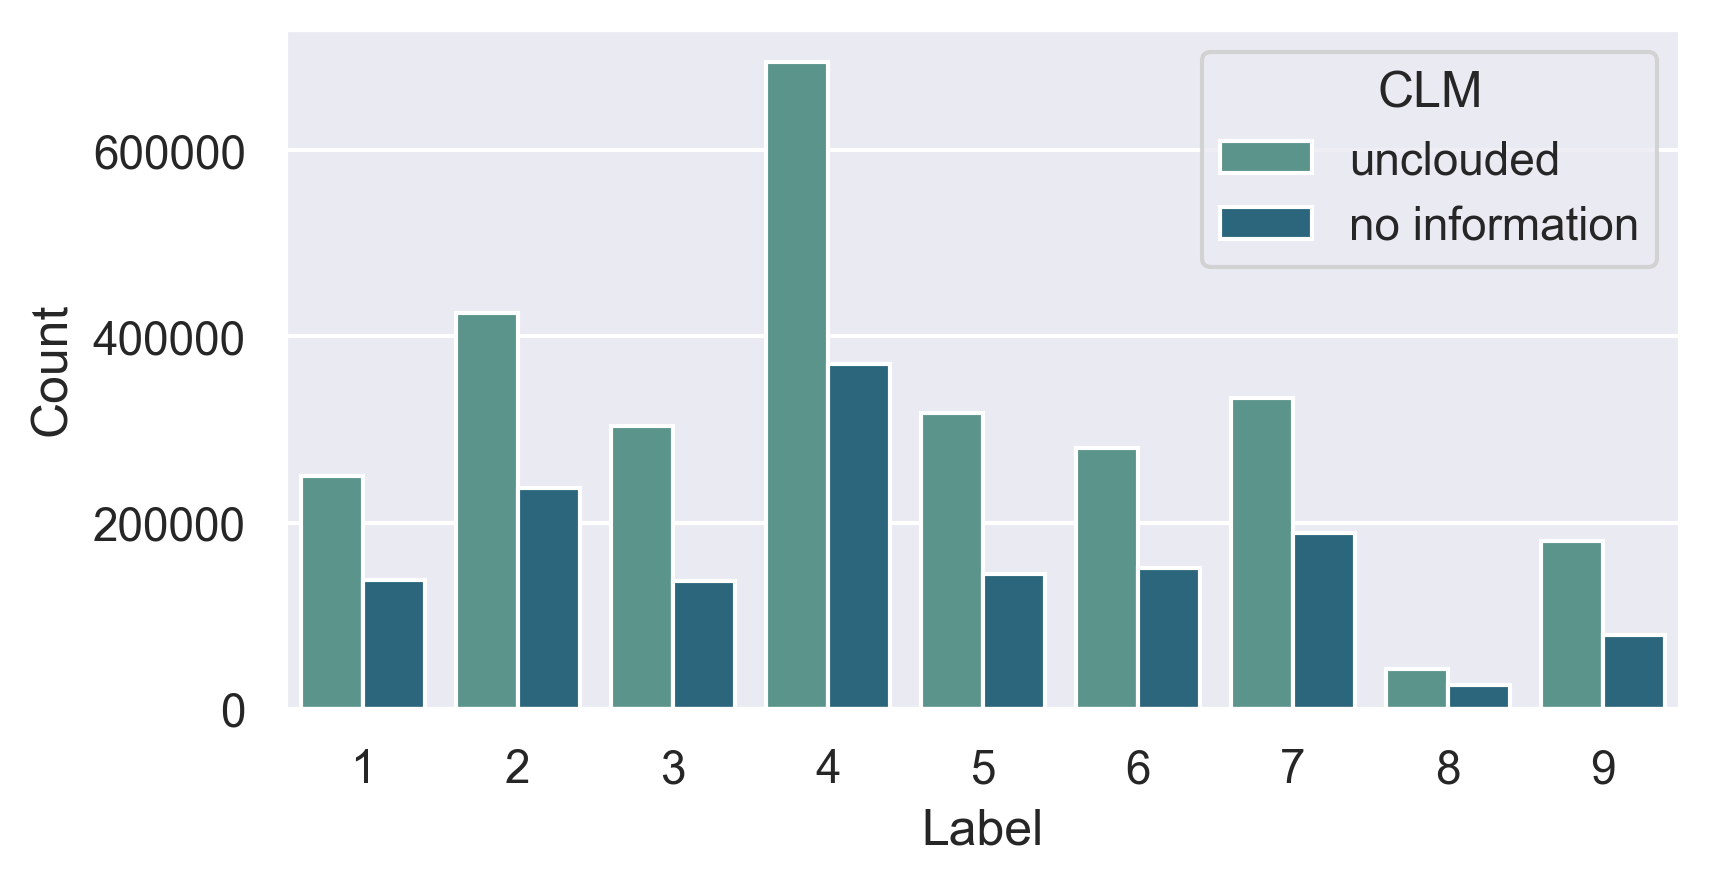

In [12]:
# plot the cloud mask info for each label 
sns.barplot(x='Label', y='Count', hue='CLM', palette='crest', data=cloudmask_labels)
plt.legend(title='CLM', loc='upper right');

We also want to see which months are manly affected by the different CLM states.

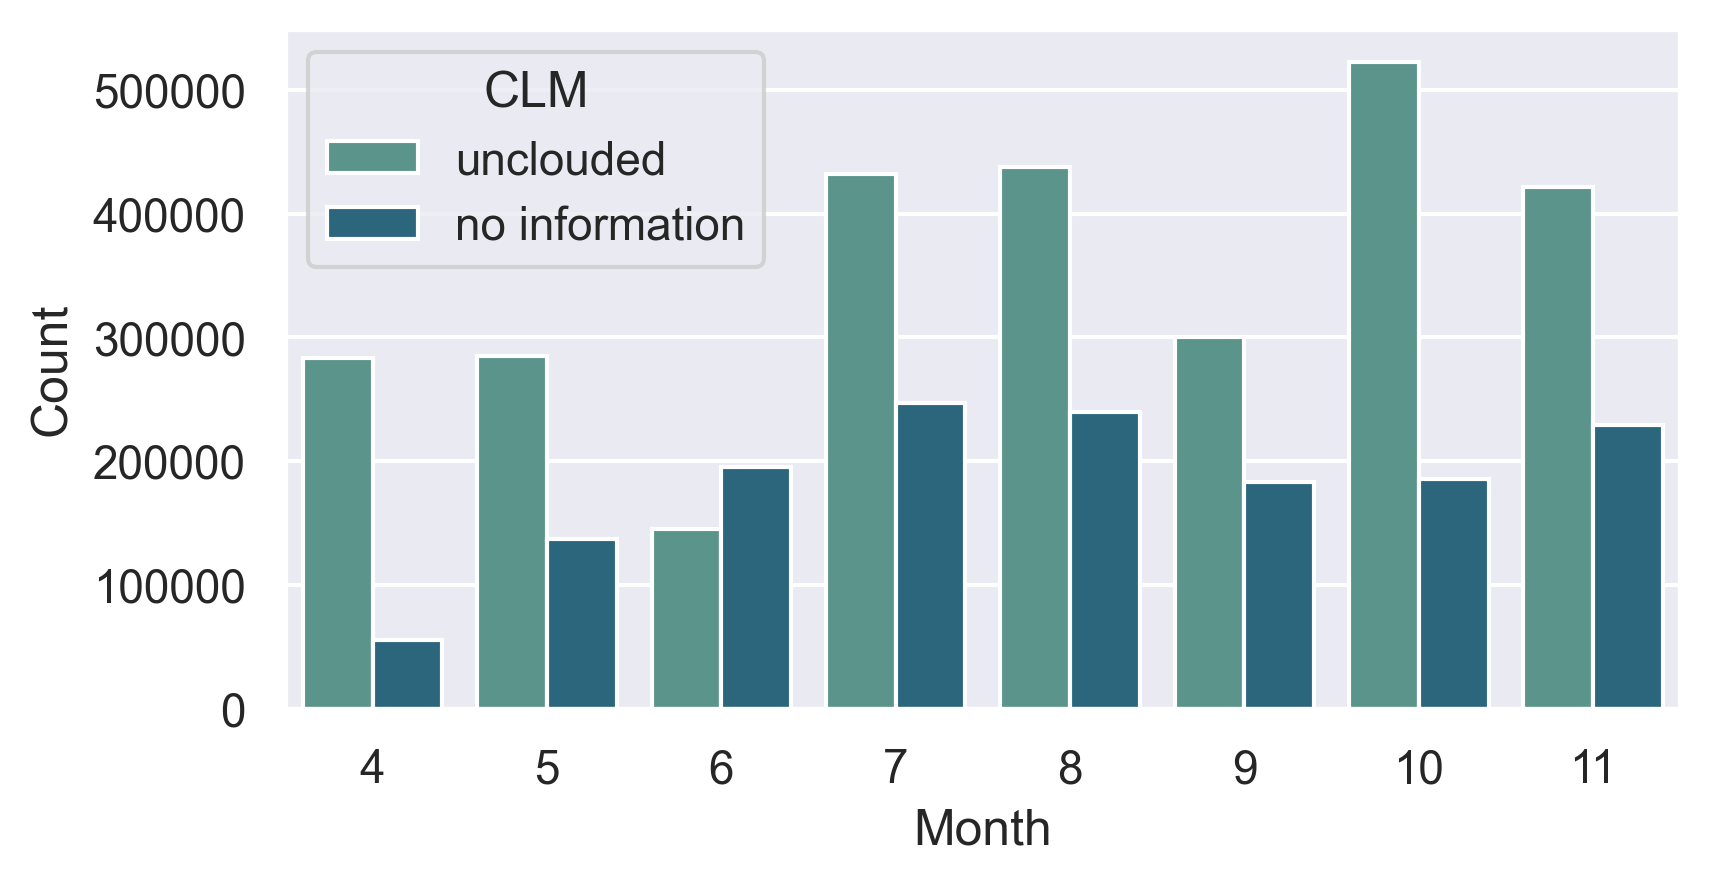

In [13]:
# get data frame for the CLM of the month
cloudmask_months = get_cloudmask_frame(df, 'month')
# plot the cloud mask info for each label 
sns.barplot(x='Month', y='Count', hue='CLM', palette='crest', data=cloudmask_months)
plt.legend(title='CLM', loc='upper left');